# Сборный проект — 2

**HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.**

**Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.**

**У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.**

**Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.**

## Задача: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

**Импортируем необходимые библиотеки и функции:**

In [1]:
!pip install scikit-learn==1.1.3 -q
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install phik -q
import phik
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import (roc_auc_score, 
                                make_scorer, 
                                mean_absolute_error, 
                                mean_squared_error, 
                                r2_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split, cross_val_score)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif 

In [3]:
train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job.info() 
train_job.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.info() 
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [5]:
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target.info() 
test_target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Все таблицы импортировались коректно, можно переходить к предобработке данных.**

### Предобработка данных

**Проверим таблицы на пропуски и дубликаты:**

In [6]:
train_job.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [7]:
train_job[train_job.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


**Пока с ними ничего делать не будем, заполним пропуски в пайплайне.**

**Проверим на дубликаты:**

In [8]:
train_job.duplicated().sum()

0

**Cледующая таблица:**

In [9]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [10]:
test_features[test_features.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


**Тут поступим аналогично, оставим для заполнения в пайплайне. Дубликаты:**

In [11]:
test_features.duplicated().sum()

0

**Последняя таблица:**

In [12]:
test_target.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [13]:
test_target.duplicated().sum()

0

**Тут ни пропусков, ни дубликатов. Мы исследовали данные, обнаружили пропуски. Оставим их для предобработки в пайплайне.**

In [14]:
train_job['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [15]:
train_job['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [16]:
train_job['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [17]:
train_job['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [18]:
train_job['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

**В первой таблице неявных дубликатов и пробелов не обнаружено. Значения nan оставим для предобработке в пайплайне. Перейдем ко второй таблице:**

In [19]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

**Заменим пропуски на nan:**

In [20]:
test_features['dept'].replace(' ', np.nan, inplace=True)
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [21]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [22]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

**Заменим пропуски на nan:**

In [23]:
test_features['workload'].replace(' ', np.nan, inplace=True)
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [24]:
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [25]:
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

**Во второй таблице тоже нет неявных дубликатов**

### Исследовательский анализ данных

**Исследуем по очереди все признаки из таблиц с помощью графиков. Для этого напишем две функции, строящие графики для количественных и категориальных:**

In [26]:
def charts_cat(df, column):

    counts = df[column].value_counts()
    counts.plot(kind='pie', figsize=(12,5), autopct='%1.1f%%')
    plt.title(f'График соотношения для {column}')
    plt.ylabel('')
    plt.show()

In [27]:
def charts(df, column):

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=20)
    plt.title(f'Гистограмма для {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Ящик с усами для {column}')
    plt.tight_layout()
    plt.show()

**Начнем с первой таблицы (во всех таблицах признак id будем игнорировать, т.к. он является просто порядковым номером):**

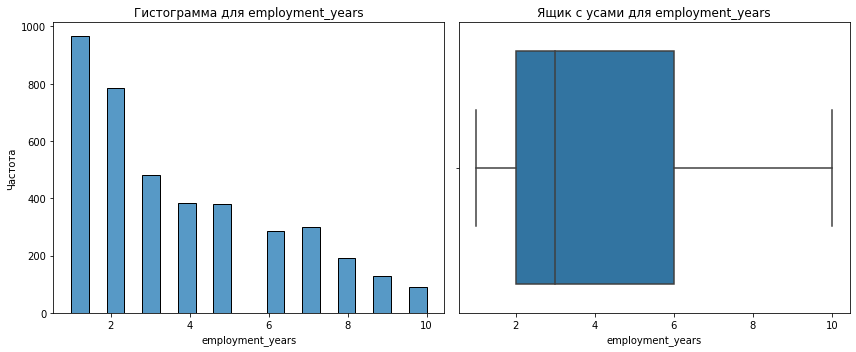

In [28]:
charts(train_job, 'employment_years')

**Большинство работников работают в компании от одного до трех лет. Самые старые сотрудники работатю до 10 лет.**

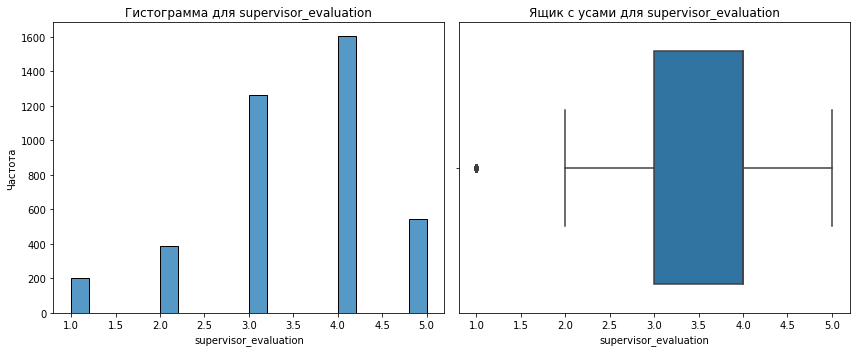

In [29]:
charts(train_job, 'supervisor_evaluation')

**Большинство руководителей оценивают работу своих сотрудников как удовлетворительно. Однако есть около 600 работников, чьих руководителей их работа не удовлетворяет.**

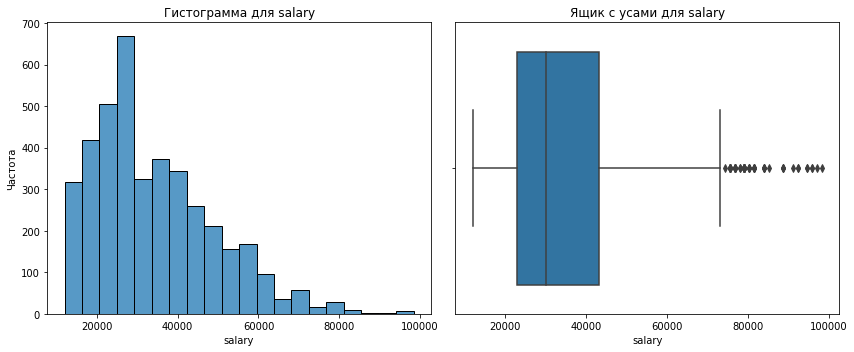

In [30]:
charts(train_job, 'salary')

**Есть работники, получающие менее 10000 в месяц (возможно это стажеры, или работники на часть ставки). Самые оплачиваемые сотрудники получают до 100000 в месяц, средняя же зарплата составляет около 25000.**

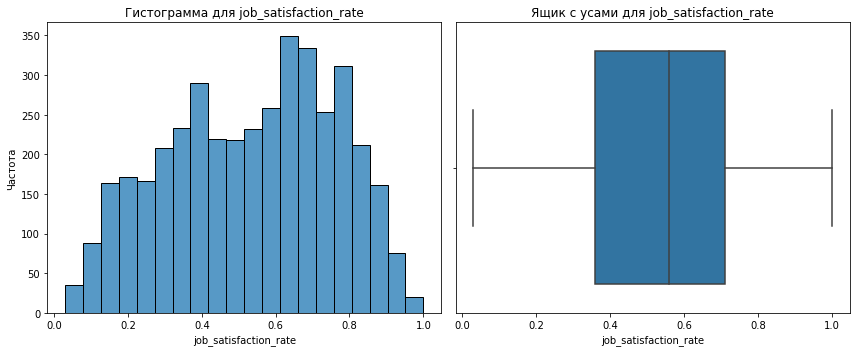

In [31]:
charts(train_job, 'job_satisfaction_rate')

**Целевой признак распределен нормально от чуть более чем нуля до единицы.**

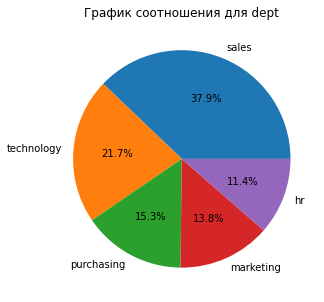

In [32]:
charts_cat(train_job, 'dept')

**Видим распределение профессий в компании, большинство людей работают в продажах**

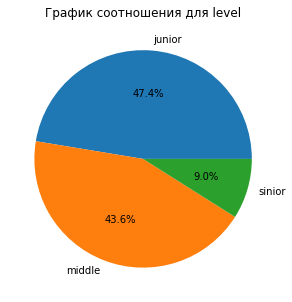

In [33]:
charts_cat(train_job, 'level')

**Видим уровни сотрудников, чуть более 47% от общего числа составляют джуны, на 4% меньше мидлов, и всего 9% сеньеров**

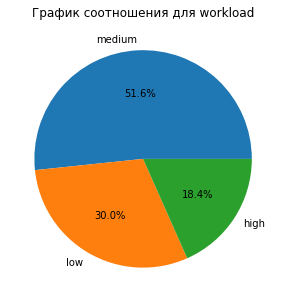

In [34]:
charts_cat(train_job, 'workload')

**Чуть более половины сотрудников имеют среднюю нагрузку, 30% низкую и 18,4% высокую.**

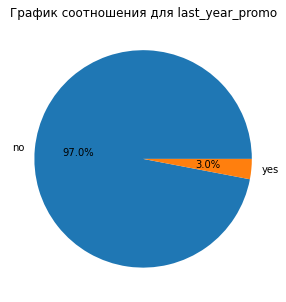

In [35]:
charts_cat(train_job, 'last_year_promo')

**Только 3% сотрудников получили за последний год повышение**

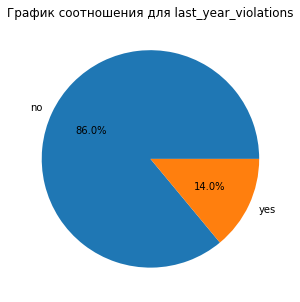

In [36]:
charts_cat(train_job, 'last_year_violations')

**14% сотрудников нарушали трудовой договор за последний год**

**Перейдем к датафрейму с тестовой выборкой test_features. Но перед этим напишем две других функции, которые будут строить графики для одного признака сразу из двух таблиц, чтобы мы могли наглядно увидеть разницу между ними, если она есть:**

In [37]:
def charts_cat2(df, df1, column):
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    counts = df[column].value_counts()
    counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'График соотношения для {column} первой таблицы')
    plt.ylabel('')
    plt.subplot(1, 2, 2)
    counts1 = df1[column].value_counts()
    counts1.plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'График соотношения для {column} второй таблицы')
    plt.ylabel('')
    plt.show()

In [38]:
def charts2(df, df1, column):

    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    sns.histplot(df[column], bins=20)
    plt.title(f'Гистограмма для {column} первой таблицы')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.subplot(2, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Ящик с усами для {column} первой таблицы')
    plt.subplot(2, 2, 3)
    sns.histplot(df1[column], bins=20)
    plt.title(f'Гистограмма для {column} второй таблицы')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df1[column])
    plt.title(f'Ящик с усами для {column} второй таблицы')
    plt.tight_layout()
    plt.show()

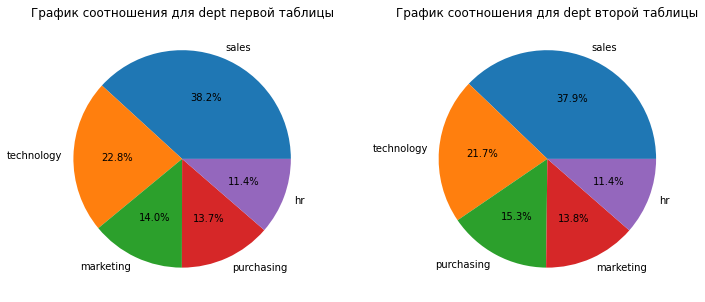

In [39]:
charts_cat2(test_features, train_job, 'dept')

**Видим какую-то маленькую категорию, скорее всего это оставленные нами нули (на графике таблице train_job они не отображаются, т.к. нули записаны как na, а не ' '), проверим так ли это:**

In [40]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

**Видим пять тех же профессий и нули. При этом пять профессий распределены примерно одинаково в обоих таблицах**

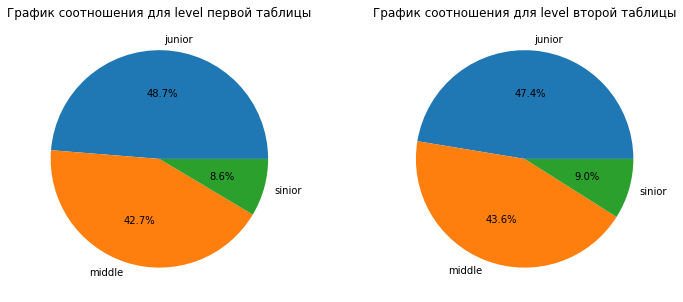

In [41]:
charts_cat2(test_features, train_job, 'level')

**И тут все примерно идиентично**

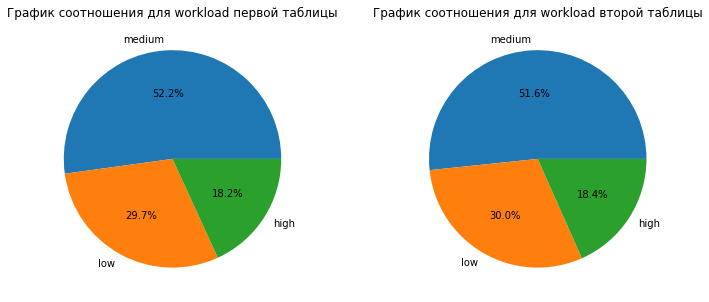

In [42]:
charts_cat2(test_features, train_job, 'workload')

In [43]:
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

**Ситуация как с признаком dept, соотношения похожи**

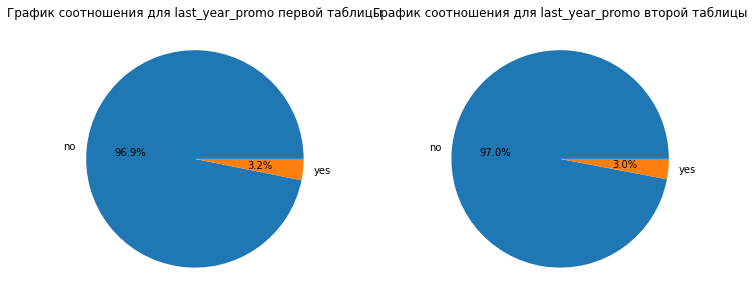

In [44]:
charts_cat2(test_features, train_job, 'last_year_promo')

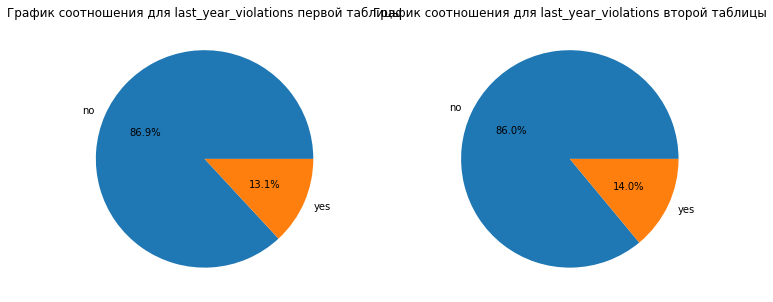

In [45]:
charts_cat2(test_features, train_job, 'last_year_violations')

**С повышениями и нарушениями договора все хорошо, соотношения практически одинаковые**

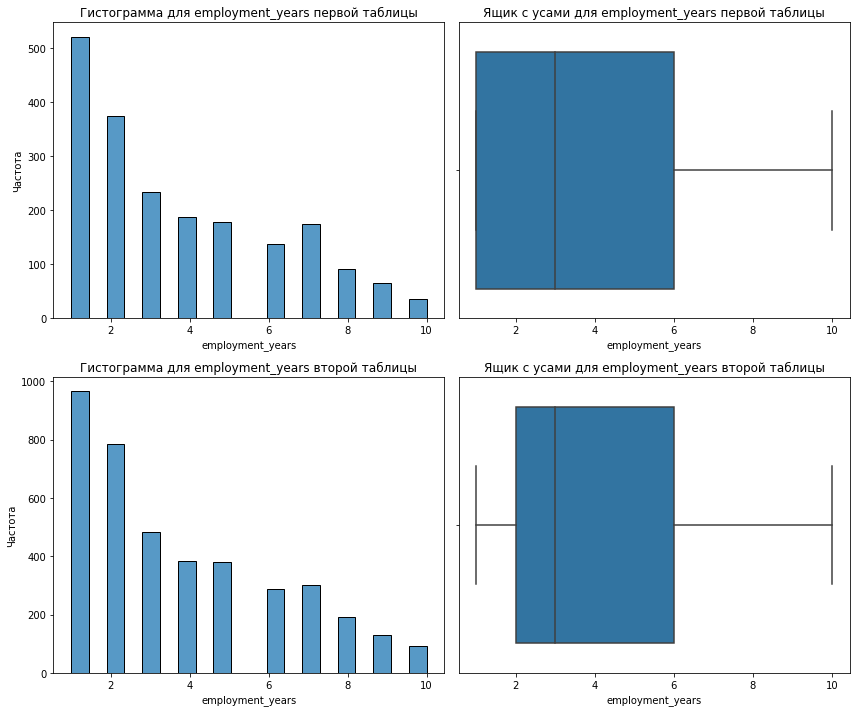

In [46]:
charts2(test_features, train_job, 'employment_years')

**Распределение длительности работы очень похоже, все хорошо**

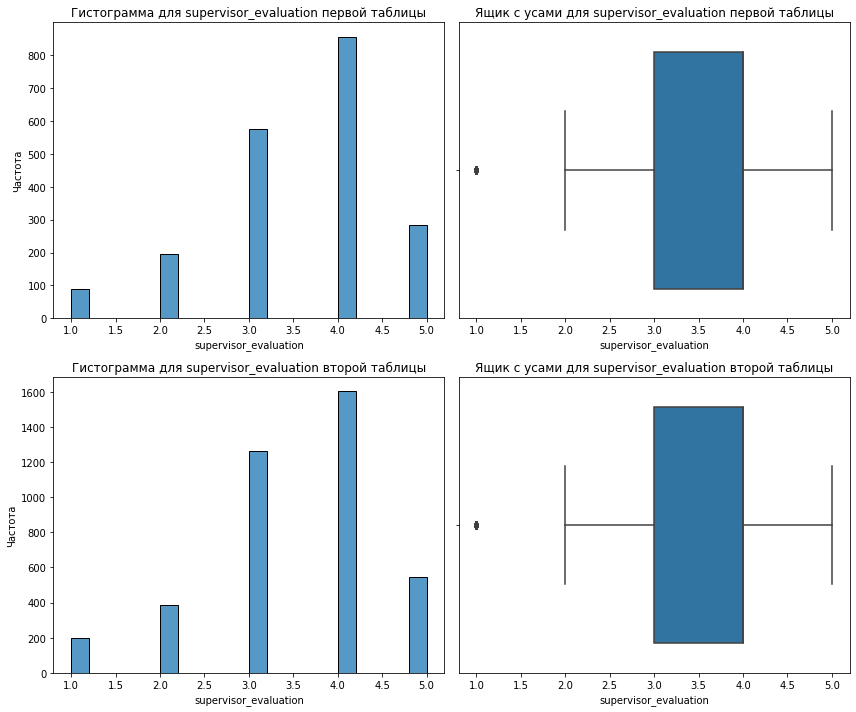

In [47]:
charts2(test_features, train_job, 'supervisor_evaluation')

**Практически идиентичное распределение, идем дальше:**

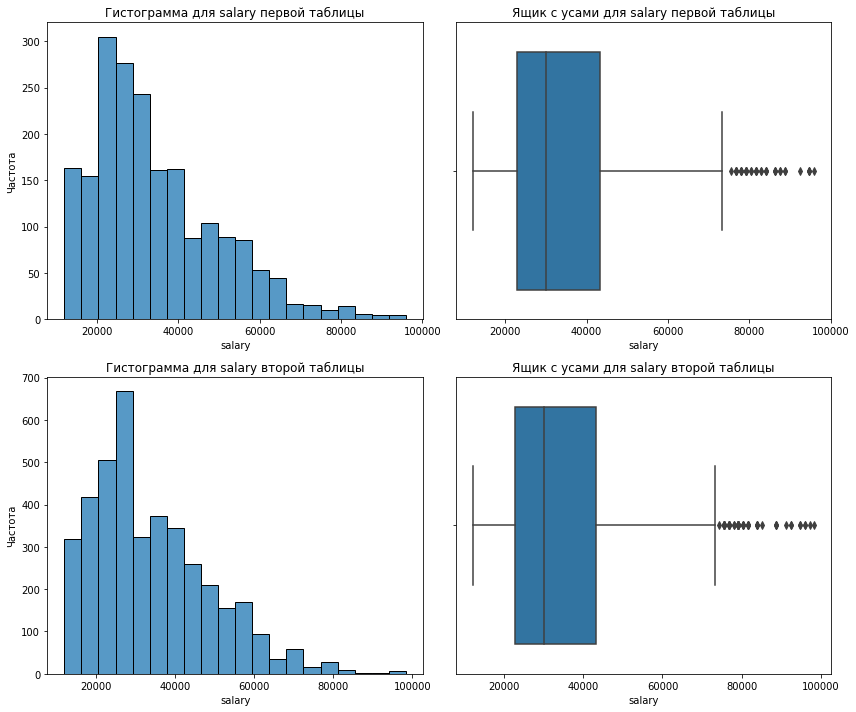

In [48]:
charts2(test_features, train_job, 'salary')

**И распределение зарплат у них очень похожи.**

**Посмотрим последнюю таблицу:**

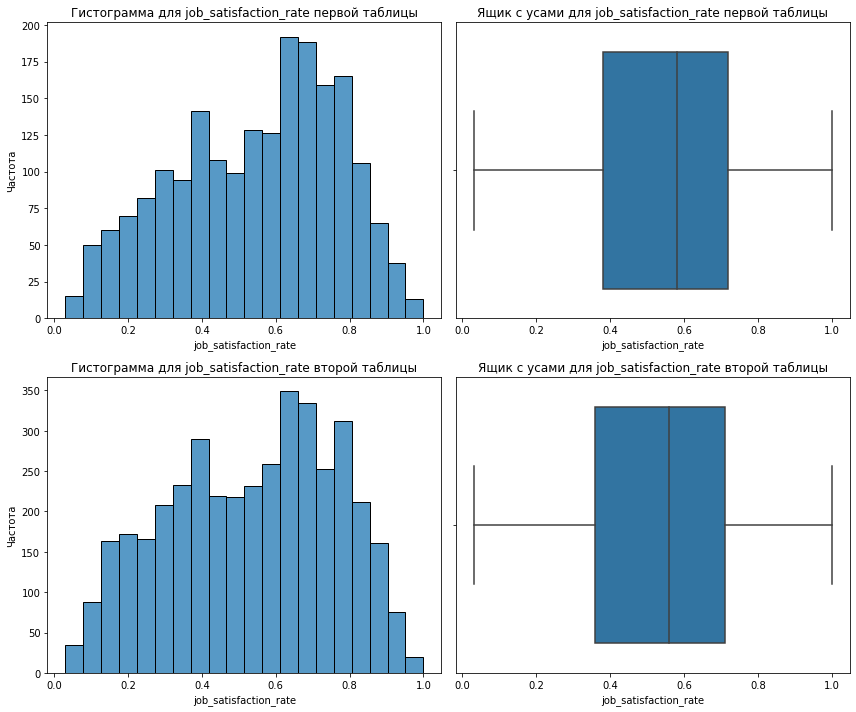

In [49]:
charts2(test_target, train_job, 'job_satisfaction_rate')

**Тут также все хорошо.**

**В ходе исследователского анализа данных, посмотрели на каждый признак, сравнили их распределения из двух таблиц. Можно сформировать портрет "среднего" сотрудника компании: джуниор работник сферы продаж со стажем 2 года, зарплатой около 30000, удовлетворен своей работой чуть выше среднего.**

**Можно переходить к отбору признаков для модели.**

### Подготовка данных

**Для начала взглянем на корреляцию признаков тренировочной выборки (id удалим, т.к. он нам не понадобится):**

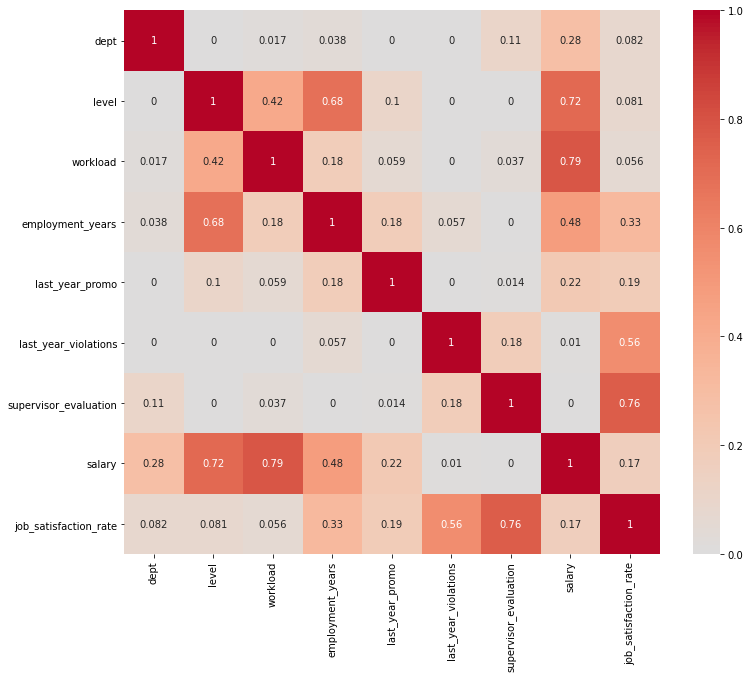

In [50]:
train_job_copy = train_job
train_job = train_job.drop(['id'], axis=1)
phik_matrix = train_job.phik_matrix(interval_cols=['id','employment_years','supervisor_evaluation','salary','job_satisfaction_rate'])
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', center=0)
plt.show();

**Сильнее всего с целевым признаком корелируют оценка начальника, нарушения трудового договора за последний год и длительность работы в компании. Мультикорреляции среди признаков не обнаружено, можно приступать к обучению модели.**

###  Обучение моделей

**Сделаем тренировочную и тестовую выборки:**

In [51]:
RANDOM_STATE = 42
X_train = train_job.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job['job_satisfaction_rate']
#y_train = pd.DataFrame(y_train, columns=['job_satisfaction_rate'])
X_test = test_features.sort_values('id').drop(['id'], axis=1)
y_test = test_target.sort_values('id').drop(['id'], axis=1)

**Обозначим какие признаки требуют кодирования, а какие масштабирования. Т.к. признак 'тип_сервиса' является порядковым, его будем кодировать другим способом.**

In [52]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

num_columns = ['employment_years', 'salary', 'supervisor_evaluation'] 

**Будем использовать SimpleImputer для заполнения пропусков (которые мы оставили на втором пункте) на разных этапах работы пайплана. Добавляем OHE-кодирование в пайплайн:**

In [53]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

**Добавляем Ordinal-кодирование в пайплайн:**

In [54]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

**Объединяем шаги подготовки и создаем итоговый пайплайн:**

In [55]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

**Зададим словарь гиперпараметров для моделей и вариантов масштабирования:**

In [56]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,11),
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

**По условию будем использовать особую метрику SMAPE:**

In [57]:
def smape(y_true, y_pred):
    y_true, y_pred = y_true, np.array(y_pred)
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [58]:
y_train

0       0.58
1       0.76
2       0.11
3       0.37
4       0.20
        ... 
3995    0.45
3996    0.68
3997    0.76
3998    0.48
3999    0.18
Name: job_satisfaction_rate, Length: 4000, dtype: float64

In [59]:
y_test['job_satisfaction_rate']

1734    0.80
1467    0.84
190     0.79
60      0.75
231     0.69
        ... 
1026    0.79
1613    0.76
780     0.48
931     0.57
334     0.35
Name: job_satisfaction_rate, Length: 2000, dtype: float64

**Создаем собственный скорер для нашей метрики:**

In [60]:
smape_scorer = make_scorer(smape, greater_is_better=False)

**Запускаем поиск лучшей модели:**

In [61]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, np.array(y_train))
best_params = randomized_search.best_params_
best_model = randomized_search.best_estimator_
best_score = randomized_search.best_score_
print('Лучшие параметры:', best_params)
print('Лучшая модель:', best_model)
print ('Метрика лучшей модели на валидационной выборке:', best_score)

Лучшие параметры: {'preprocessor__num': StandardScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 6, 'models__max_depth': 10, 'models': DecisionTreeRegressor(max_depth=10, min_samples_leaf=6, min_samples_split=10,
                      random_state=42)}
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=

In [62]:
y_pred = best_model.predict(X_test) 
 
smape_value = smape(y_test['job_satisfaction_rate'], y_pred) 
print(f'SMAPE на тестовой выборке: {smape_value:.2f}')

mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse) 
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}") 
print(f"Mean Squared Error (MSE): {mse:.2f}") 
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}") 
print(f"R-squared (R²): {r2:.2f}")

SMAPE на тестовой выборке: 14.55
Mean Absolute Error (MAE): 0.06
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.08
R-squared (R²): 0.86


### Оформление выводов

**В ходе нашего исследования, лучше всего себя показала регресионная модель решающего дерева с гиперпараметрами max_depth=10, min_samples_leaf=9, min_samples_split=3, random_state=42. Мы удовлетворили условию smape<=15, а также убедились на других метриках в высоком качестве модели.**

## Задача: предсказание увольнения сотрудника из компании

### Загрузка данных

**Загрузим датафреймы с тренировочной выборкой, целевым признаком тестовой выборки (входные признаки тестовой выборки остаются те же):**

In [63]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.info() 
train_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [64]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.info() 
test_target_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Данные загрузились корректно, приступим к предобработке.**

### Предобработка данных

**Проверим таблицы на пропуски:**

In [65]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [66]:
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

**Проверим на дубликаты:**

In [67]:
train_quit.duplicated().sum()

0

In [68]:
test_target_quit.duplicated().sum()

0

**Пропусков и дубликатов не обнуружено, приступим к исследовательскому анализу.**

**Проверим на пробелы и неявные дубликаты таблицу с тренировочными данными:**

In [69]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [70]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [71]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [72]:
train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [73]:
train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [74]:
train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

**Неявных дубликатов и пробелов не найдено. Проверим таблицу с целевым признаком для тренировочной выборки:**

In [75]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

**Тут тоже все хорошо**

### Исследовательский анализ данных

**С помощью графиков, посмотрим на распределения и соотношения признаков. Смотреть будем в сравнении с графиками тестовой выборки:**

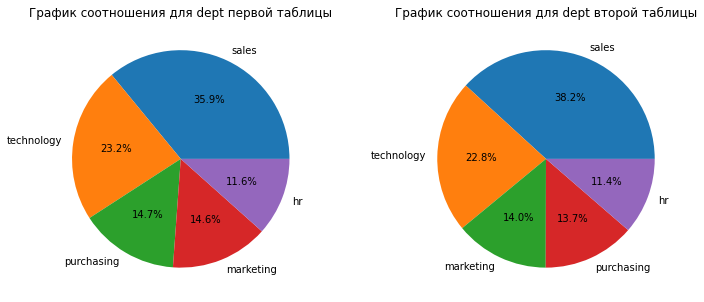

In [76]:
charts_cat2(train_quit, test_features, 'dept')

**Очень похожее соотношение, идем дальше**

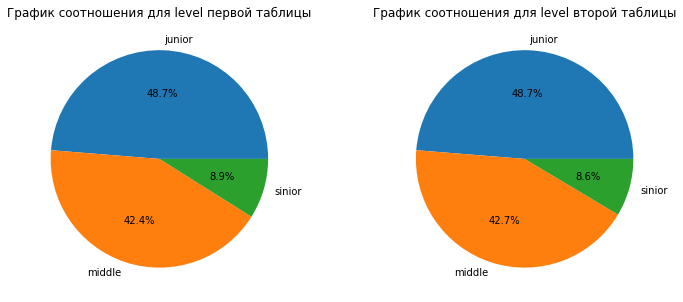

In [77]:
charts_cat2(train_quit, test_features, 'level')

**Соотношение практически 1в1, все хорошо**

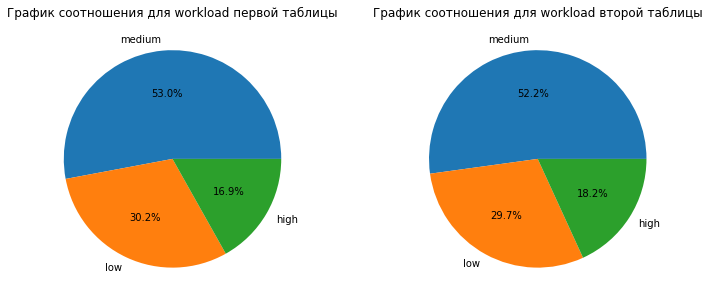

In [78]:
charts_cat2(train_quit, test_features, 'workload')

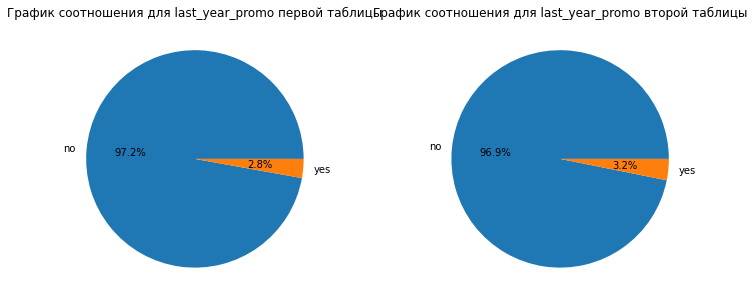

In [79]:
charts_cat2(train_quit, test_features, 'last_year_promo')

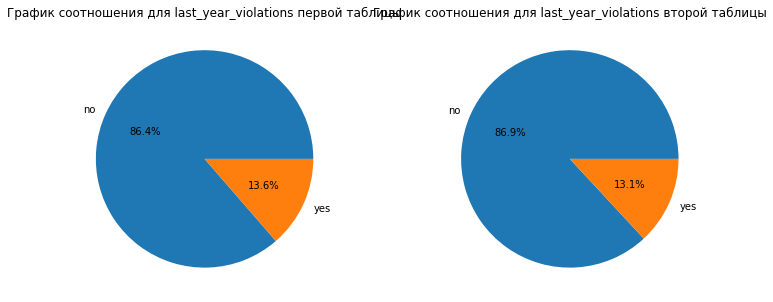

In [80]:
charts_cat2(train_quit, test_features, 'last_year_violations')

**Со всеми входными категориальными признаками все хорошо, проверим количественные:**

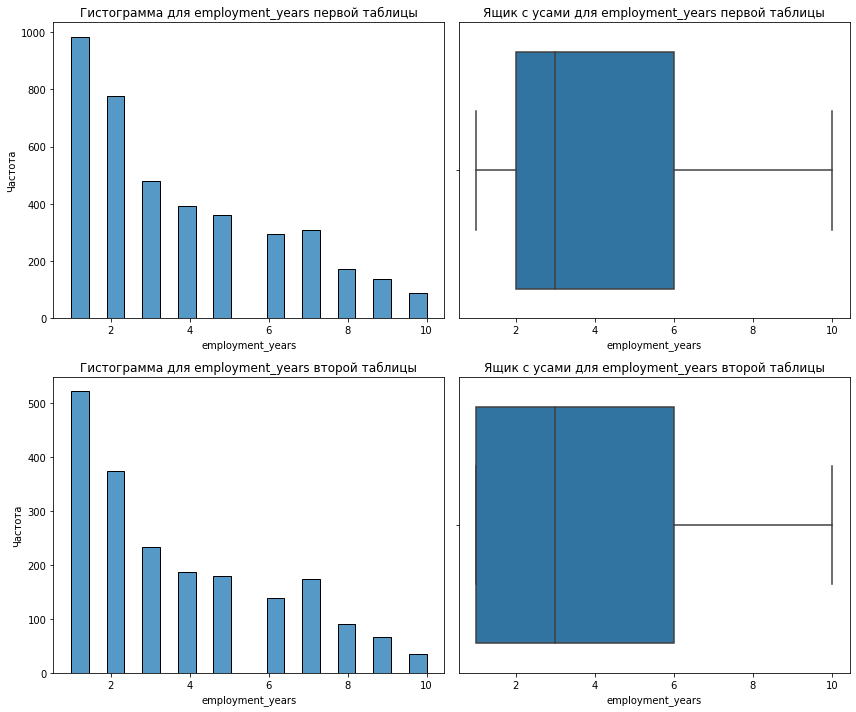

In [81]:
charts2(train_quit, test_features, 'employment_years')

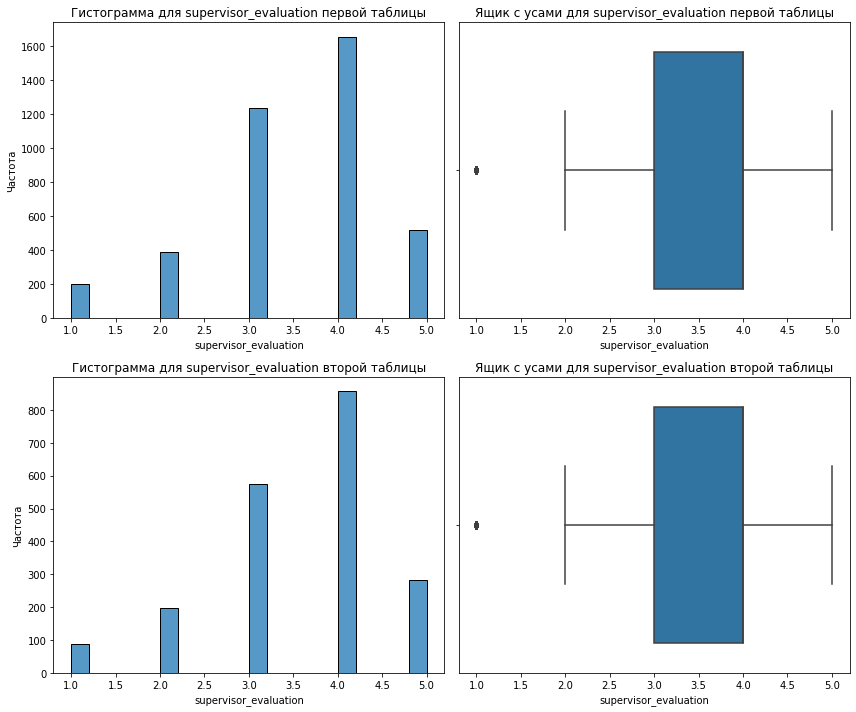

In [82]:
charts2(train_quit, test_features, 'supervisor_evaluation')

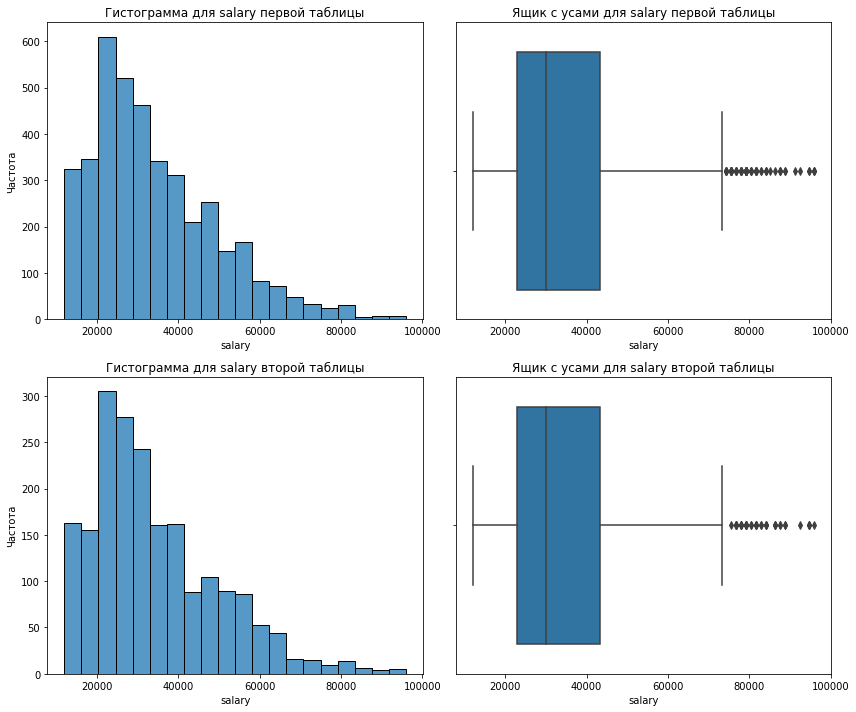

In [83]:
charts2(train_quit, test_features, 'salary')

**С количественными признаками все хорошо, похожие графики распределения. Аномалий не обнаружено. Посмотрим на целевой признак в двух таблицах:**

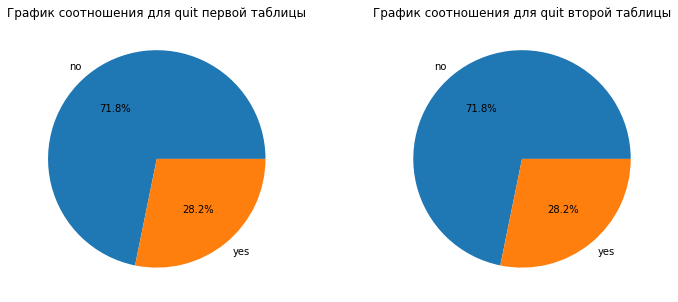

In [84]:
charts_cat2(train_quit, test_target_quit, 'quit')

**Видим, одинаковое соотношение, 28.2% сотрудников уволились из компании.**

**Возьмем сотрудников, которые уволились, и составим их портрет:**

In [85]:
train_quit_yes = train_quit[train_quit['quit'] == 'yes']

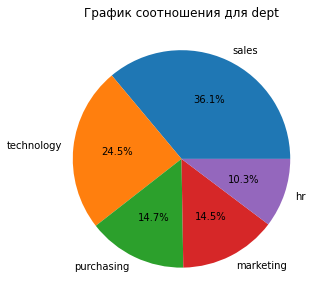

In [86]:
charts_cat(train_quit_yes, 'dept')

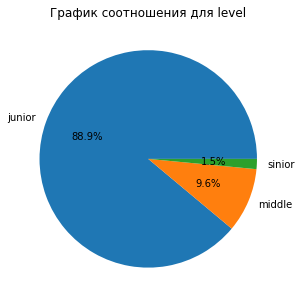

In [87]:
charts_cat(train_quit_yes, 'level')

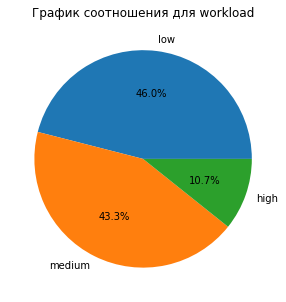

In [88]:
charts_cat(train_quit_yes, 'workload')

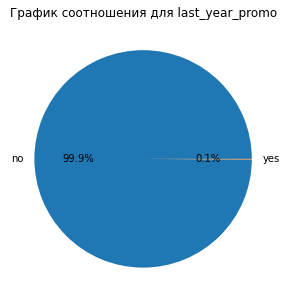

In [89]:
charts_cat(train_quit_yes, 'last_year_promo')

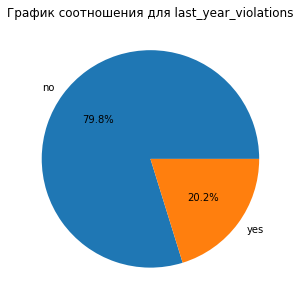

In [90]:
charts_cat(train_quit_yes, 'last_year_violations')

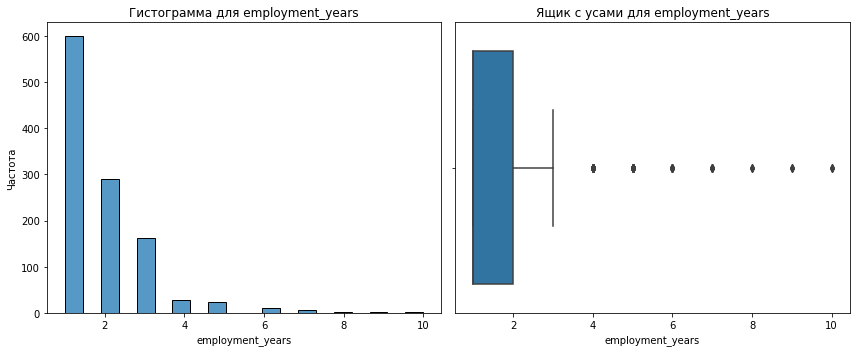

In [91]:
charts(train_quit_yes, 'employment_years')

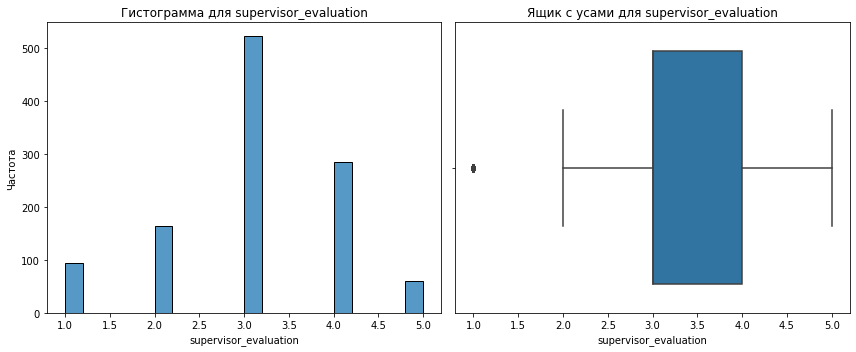

In [92]:
charts(train_quit_yes, 'supervisor_evaluation')

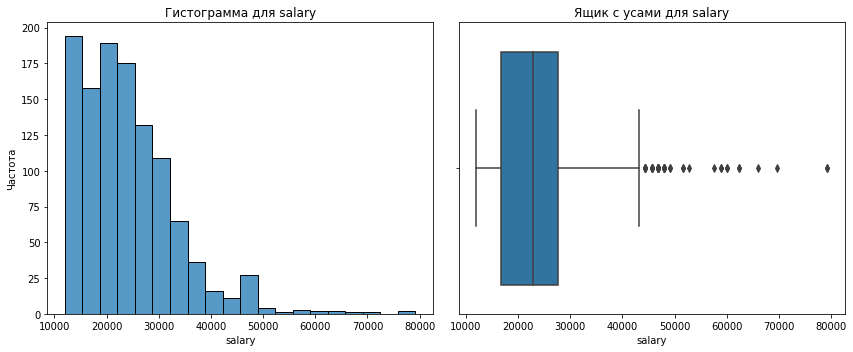

In [93]:
charts(train_quit_yes, 'salary')

**Глядя на эти графики можно составить портрет увольвшегося сотрудника. Это джуниор работник сфреы продаж или сферы технологий, со средней или низкой нагрузкой, не уходивший в отпуск и не нарушавший трудового договора за последний год. Отработал в компании 1-2 года, начальник оценивает его работу на 3, его зарплата составляет около 22000. Сравним некоторые показатели с работниками, которые не уволились:**

In [94]:
train_quit_no = train_quit[train_quit['quit'] == 'no']

**Сравним зарплаты таких работников:**

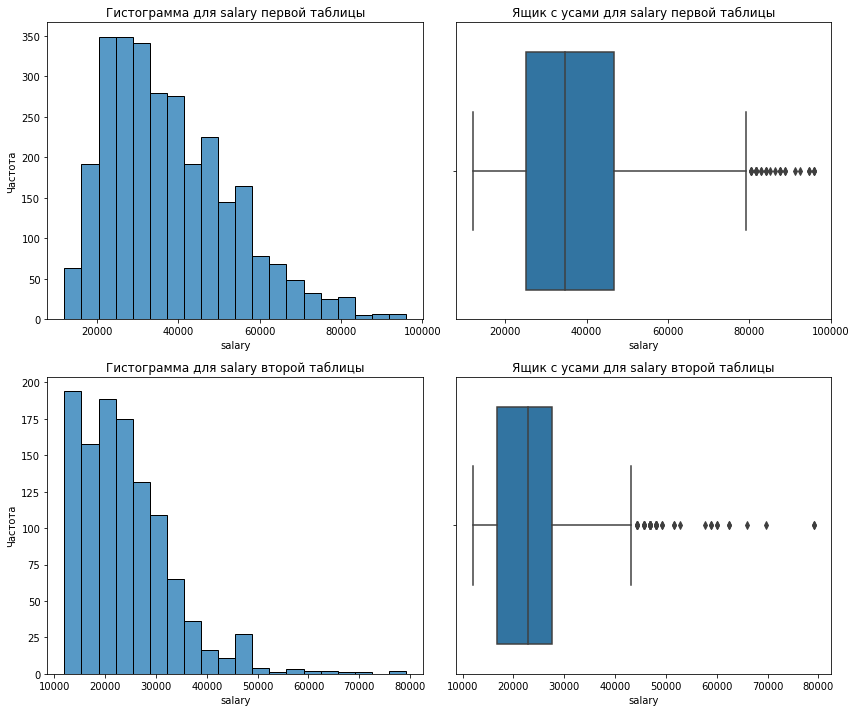

In [95]:
charts2(train_quit_no, train_quit_yes, 'salary')

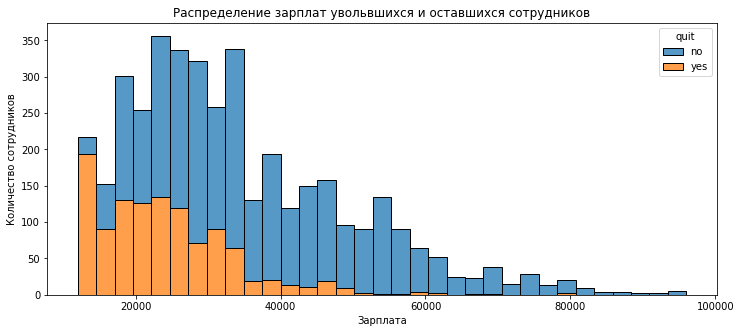

In [96]:
plt.figure(figsize=(12, 5))
sns.histplot(data=train_quit, x='salary', hue='quit', multiple='stack')
plt.xlabel('Зарплата') 
plt.ylabel('Количество сотрудников') 
plt.title('Распределение зарплат увольвшихся и оставшихся сотрудников') 
plt.show()

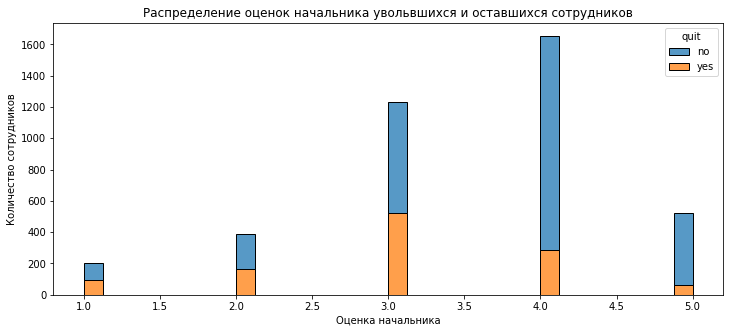

In [97]:
plt.figure(figsize=(12, 5))
sns.histplot(data=train_quit, x='supervisor_evaluation', hue='quit', multiple='stack')
plt.xlabel('Оценка начальника') 
plt.ylabel('Количество сотрудников') 
plt.title('Распределение оценок начальника увольвшихся и оставшихся сотрудников') 
plt.show()

**Зарплата оставшихся сотрудников заметно выше, в среднем около 35000. Взглянем на оценку начальника:**

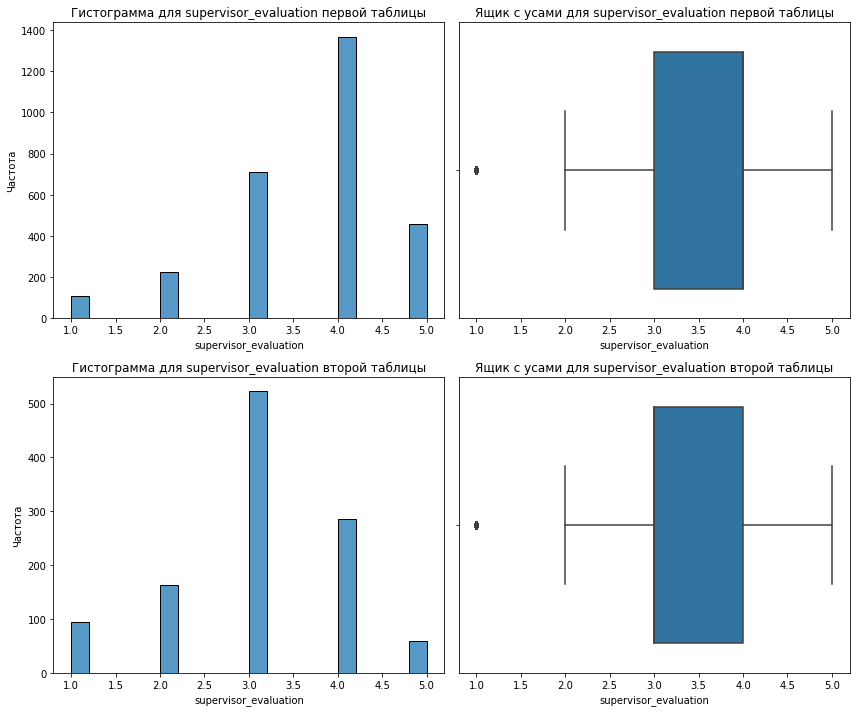

In [98]:
charts2(train_quit_no, train_quit_yes, 'supervisor_evaluation')

**У оставшихся сотрудников больше оценок 4 и 5. Посмотрим на отдел работников:**

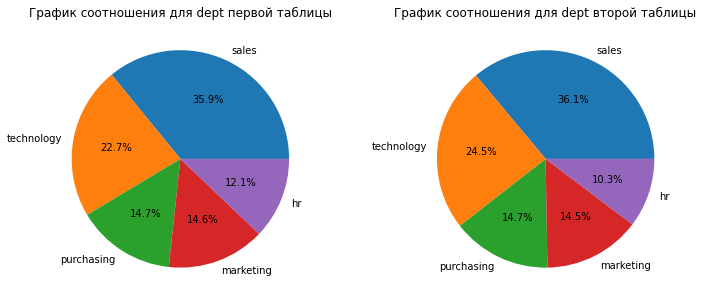

In [99]:
charts_cat2(train_quit_no, train_quit_yes, 'dept')

**Соотношения отделов прмерно одинаковы.**

**Можно сделать вывод, что у оставшихся работников значительно выше зарплата, а также оценки их работы начальником.**

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

**Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Для этого в начале добавим оба целевых признака в таблицу с тестовыми данными:** 

In [100]:
test_features_copy = test_features
test_features_copy = pd.merge(test_features_copy, test_target, on='id')
test_features_copy = pd.merge(test_features_copy, test_target_quit, on='id') 

**Теперь разделим таблицу на ушедших и оставшихся:**

In [101]:
test_features_copy_no = test_features_copy[test_features_copy['quit']=='no']
test_features_copy_yes = test_features_copy[test_features_copy['quit']=='yes']

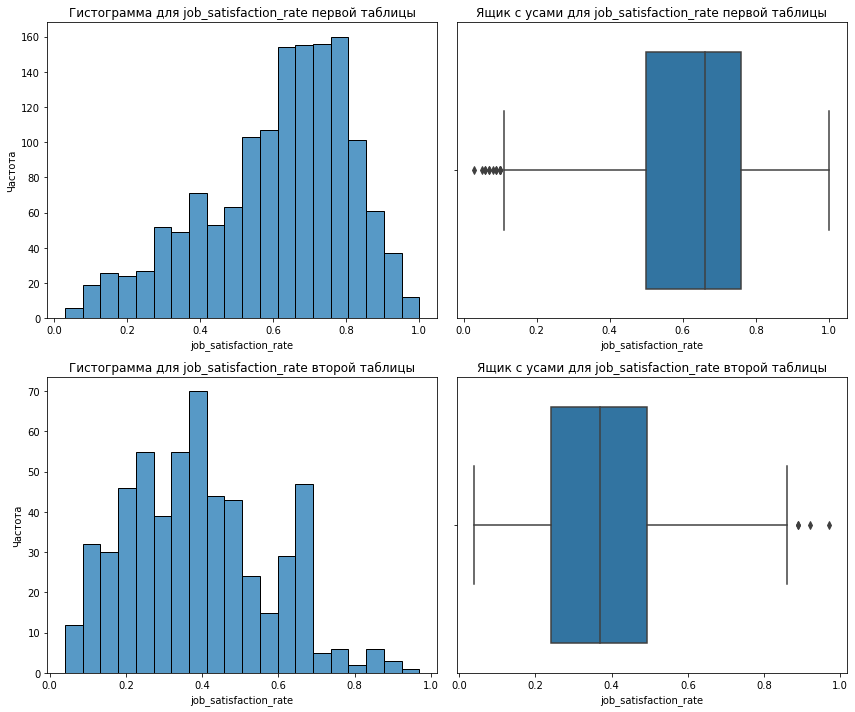

In [102]:
charts2(test_features_copy_no, test_features_copy_yes, 'job_satisfaction_rate')

**Видим, что среднее значение для оставшихся на работе значительно выше (более 0.6), чем у ушедших (менее 0.4). Распределены же оценки от 0 до 1, однаков смещены они ближе к среднему значению.**

### Добавление нового входного признака

**Добавим job_satisfaction_rate, предсказанный моделью в первой задаче:**

In [103]:
test_features['prediction'] = best_model.predict(test_features.drop(['id'], axis=1))

**Также добавим этот признак в тренировочную таблицу для второй задачи. Для этого сделаем предсказания:**

In [104]:
train_quit_copy = train_quit.drop(['id', 'quit'], axis=1)

In [105]:
model = best_model

In [106]:
y_pred2 = model.predict(train_quit_copy) 

In [107]:
preds2 = pd.DataFrame(y_pred2, columns=['prediction'])

In [108]:
train_quit = pd.concat([train_quit, preds2], axis=1)

In [109]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,prediction
0,723290,sales,middle,high,2,no,no,4,54000,no,0.601169
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.828889
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.402143
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.794667


<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

### Подготовка данных

**Посторим матрицу корреляции:**

In [110]:
train_quit_copy = train_quit
train_quit = train_quit.drop(['id'], axis=1)

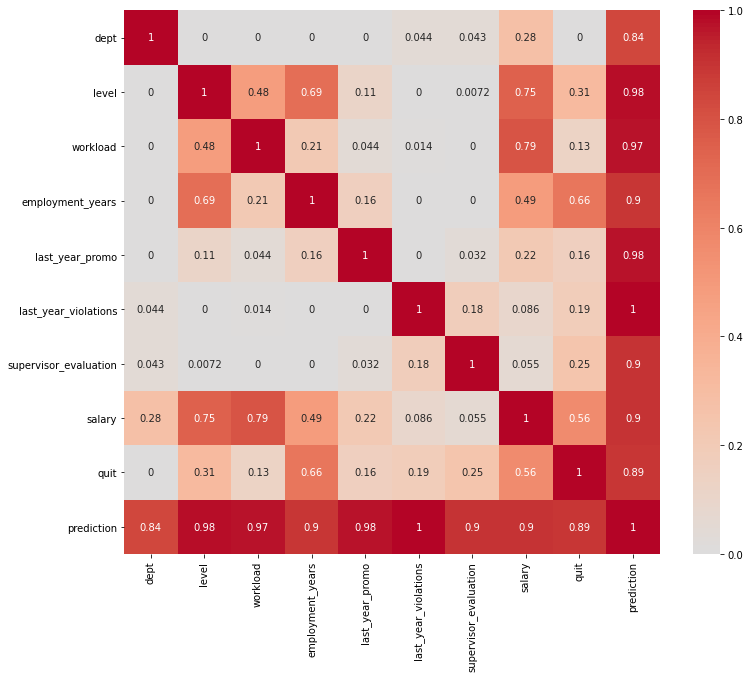

In [111]:
phik_matrix = train_quit.phik_matrix(interval_cols=['employment_years','supervisor_evaluation','salary','job_satisfaction_rate'])
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', center=0)
plt.show();

**Видим, что новый признак имеет сильную свзязь с остальными признаками.**

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Днйствительно этот признак имеет сильное влияние
</div>

### Обучение модели

**Подготовим признаки и обучим модель в пайплайне также, как мы делали это в первой задаче:**

In [112]:
RANDOM_STATE = 42
X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']
X_test = test_features.sort_values('id').drop(['id'], axis=1)
y_test = test_target_quit.sort_values('id').drop(['id'], axis=1)

In [113]:
X_train

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,prediction
0,sales,middle,high,2,no,no,4,54000,0.601169
1,sales,junior,medium,2,no,no,4,27600,0.828889
2,purchasing,middle,medium,5,no,no,1,37200,0.402143
3,sales,junior,medium,2,no,yes,3,24000,0.340000
4,marketing,junior,medium,2,no,no,5,25200,0.794667
...,...,...,...,...,...,...,...,...,...
3995,sales,junior,medium,4,no,no,3,26400,0.508286
3996,sales,middle,high,9,no,no,4,52800,0.765798
3997,purchasing,junior,low,2,no,yes,4,12000,0.548750
3998,purchasing,middle,medium,2,no,no,4,33600,0.504667


In [114]:
ohe_columns = ['dept','last_year_violations', 'last_year_promo']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'prediction'] 

In [115]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

In [116]:
ord_pipe = Pipeline(
    [
    (
        'simpleImputer_before_ord', 
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ord',
        OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], 
                                   ['low', 'medium', 'high']
                                  ], 
                        handle_unknown='use_encoded_value', unknown_value=np.nan)
    ),
    (
        'simpleImputer_after_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
])

In [117]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
], remainder='passthrough')

In [118]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=42))
])

In [119]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),        
        'models__max_depth': (range(2, 11)),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression 
    { 
        'models': [LogisticRegression(solver='liblinear')], 
        'models__C': [0.1, 1, 10],
        'models__penalty': ['l1', 'l2'],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    # словарь для модели KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()], 
        'models__n_neighbors': [3, 5, 7, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

<div class="alert alert-success">
<b>👍 Успех:</b> Пайплайн готов!
</div>

In [120]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept',
                                                   'last_year_violations',
                                                   'last_year_promo']),
                                         

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! На кроссвалидации получилась отличная метрика!
</div>

**Протестируем на тестовой выборке:**

In [121]:
model1 = randomized_search.best_estimator_
pred_final = model1.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, pred_final)
print(f'Roc-auc на тествойо выборке: {roc_auc}')

Roc-auc на тествойо выборке: 0.9212912888441098


**Метрика на тествовой выборке соответствует условим нашей задачи.**

<div class="alert alert-success">
<b>👍 Успех:</b> И здесь нужное значение метрики достигнуто!
</div>

### Выводы

**В ходе обучения лучше всего справилась модель дерево выбора с параметрами(max_depth=10, min_samples_leaf=9, min_samples_split=3, random_state=42). Эта модель отлично показывает себя в задачах классификации, имеет широкий спекрт настройки гиперпараметров, что повлияло на лучший результат в нашей задачи.**

## Общий вывод

**В этом проекте перед нами стояли две основные задачи: построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика и построить вторую модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. В ходе выполнения задач мы успешно загрузили данные, подготовили их для работы, провели исследовательский анализ в ходе которого изучили и сравнили распределения и соотношения тестовых и тренировочных выборок, составили 'портрет' уволившегося сотрудника, подтвердили утверждение что рейтинг удовлетворенности сотрудника работой напрямую связан с его увольнением. Для каждой из задач мы написали свой пайплайн, в котором выполнили предобработку и подготовоку данных, а также подбор самой подходящей модели и ее параметров, на основе метрик smape и roc-auc. После обе модели были успешно протестированны на тестовых выборках, они обе соответствуют порогам значений, заданных в условиях к задачам. Можно дать ряд советов непорсредственно для бизннеса. Во-первых, мы убедились что рейтинг удовлетворенности работой влияет на увольнение, так что работодателю следует пересмотреть условия труда сотрудников, чей рейтинг явлется низким (если этих сотрудников компании нужно сохранить). Во-вторых, помимо рейтинга на увольнение влияют сами условия труда: запрплата, занимаемая должность. Возможно, компании следует пересмотреть условия труда относительно новых сотрудников, т.к. в основном увольняются именно они. Это может быть связано с тем, что за которткий сорк они не успели получить ту должность или зп, которая удовлетворяла бы их запросы, и просто находят другое место работы, с более комфортными для них условиями.**

<div class="alert alert-success">
<b>👍 Успех:</b> Отличная работа! Было очень приятно проверять твой проект!

Оставлю хороший учебник по ML:
+  https://academy.yandex.ru/handbook/ml

Немного новостей с мира DL(вдруг заинтересует):
+  https://habr.com/ru/company/ods/blog/686962/

Вот тут проходят всякие соревнования, можешь себя попробовать:
+  https://hacks-ai.ru/


Возможно, что нить пригодится:
+  https://arxiv.org/ftp/arxiv/papers/2201/2201.00650.pdf
+  https://github.com/slgero/testovoe


Курс от МФТИ математика для DS:

+  https://www.youtube.com/watch?v=xccjt6lOoow&list=PLk4h7dmY2eYHHTyfLyrl7HmP-H3mMAW08&index=1


Тут много соревнований/лекций:

+  https://ods.ai/

stepic NLP/CV:

+  https://stepik.org/course/54098/syllabus
+  https://stepik.org/course/50352/syllabus

Еще есть от ВШЭ:

+  https://www.youtube.com/watch?v=mwjQaNt8qxk&list=PLEwK9wdS5g0og-DcF1apxutSM0GDLHz_3&ab_channel=%D0%A4%D0%9A%D0%9D%D0%92%D0%A8%D0%AD%E2%80%94%D0%B4%D0%B8%D1%81%D1%82%D0%B0%D0%BD%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D1%8F
+  https://github.com/hse-ds/iad-deep-learning

Удачи в следующих проектах!!!
</div>
